## 行人检测

前面我们介绍了：

1. 如何定位图片中目标的位置（滑动窗口+图像金字塔）
2. 如何从图片中提取出目标的特征（方向梯度直方图）
3. 如何进行分类（分类算法）

现在我们将通过这节实验完成一个行人检测的项目。
本节实验将会应用到前面学习的所有内容，来构建一个传统的目标检测算法。

### 基本流程

简单来说行人检测就是在提供的图像中，我们想要计算机分辨出哪些是人并且用矩形框标记出人出现在图片中的哪些位置。
下图左上角图片中有一个人，如果我们想要用传统的目标检测方法检测到这个人的话，一般分为下面几个步骤。

1. 使用图像金字塔将图片按一定缩放比例生成不同尺寸图片（下图序号 1 所示）。
2. 使用滑动窗口在每张不同尺寸的图片上从左至右、从上向下滑动（下图序号 2 所示）--> 这样会生成很多小的图片。
3. 将滑动窗口滑过的每个区域使用方向梯度直方图进行特征描述，获得 HOG 特征（下图序号 3 所示）--> 对每个小图计算特征。
4. 将获取到的 HOG 特征使用机器学习分类器（支持向量机）进行分类（下图序号 4 所示）--> 对每个小图进行分类, 是否是需要的一类。
5. 最后在图片中使用矩形框标记出被分类器认为是人的类别（下图序号 5 所示）。

![](../dataset/4_pedestrian/行人检测流程.jpg)



## 模型训练

- 我们训练一个模型，给定一张图片，判断是行人还是背景。
    - 在 dataset/4_pedestrian 中包含数据集, 里面有两类, 分别是 background 和 people;
    - 我们现在需要训练一个分类器, 给定一个图像, 进行分类, 是 background 还是 people;
- 训练步骤
    - 首先将每一张图像转换为「方向梯度直方图」
    - 将「方向梯度直方图」作为输入, 训练一个 SVM 模型

### 获得数据集

In [37]:
import os

In [38]:
def preprocessing(datasetpath):
    """获取所有 image 的路径和 label

    Args:
        datasetpath (str): 数据集所在文件夹路径

    Returns:
        tuple: (dataset, labels)
    """
    dataset = [] # 存放每个图片的路径
    labels = [] # 存放路径对应的图像的类别
    
    categories = [os.path.join(datasetpath, i) for i in os.listdir(datasetpath)]
    
    for i in categories:
        dataset.extend([os.path.join(i, f) for f in os.listdir(i)])
    
    labels = [os.path.normpath(i).split("\\")[-2] for i in dataset]
    return (dataset, labels)

In [39]:
# 获得数据集
(dataset, labels) = preprocessing("../dataset/4_pedestrian/pedestrian")
print('Image Dataset Size: {}; Label Size: {}'.format(len(dataset), len(labels)))

Image Dataset Size: 2326; Label Size: 2326


### 从图像中提取「方向梯度直方图」模块

In [40]:
from skimage import feature

In [41]:
class HOG:
    def __init__(self, orientations = 9, pixelsPerCell = (8, 8),
        cellsPerBlock = (3, 3), transform = False):
        """从图像中提取特征, 计算「方向梯度直方图」

        Args:
            orientations (int, optional): 表示要将梯度方向分成几个区间. Defaults to 9.
            pixelsPerCell (tuple, optional): 表示每个 Cell 中有几个像素. Defaults to (8, 8).
            cellsPerBlock (tuple, optional): 表示每个 Block 中有几个 Cells. Defaults to (3, 3).
            transform (bool, optional): 是一个布尔类型，表示是否使用伽马校正预先对图片进行归一化处理. Defaults to False.
        """
        self.orienations = orientations
        self.pixelsPerCell = pixelsPerCell
        self.cellsPerBlock = cellsPerBlock
        self.transform = transform
        
    def describe(self, image):
        hist = feature.hog(image, orientations = self.orienations,
                           pixels_per_cell = self.pixelsPerCell,
                           cells_per_block = self.cellsPerBlock,
                           transform_sqrt = self.transform)
        return hist

### 模型训练

In [42]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import joblib
import cv2
import numpy as np

In [43]:
# 将 label 的字符转换为整数
L = LabelEncoder()
labels = L.fit_transform(labels)

In [44]:
# 从图像提取特征
hog = HOG(transform = True)

data = [] # 存储每一个图像的特征
for i in dataset:
    image = cv2.imread(i) # 读取图像
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) # 转换为灰度图
    resized = cv2.resize(gray, (64, 128), interpolation = cv2.INTER_AREA) # 图像放缩
    
    hist = hog.describe(resized) # 转换为 HOG 特征
    data.append(hist)

In [45]:
# 划分训练集和测试集
(trainData, testData, trainLabels, testLabels) = train_test_split(
    np.array(data), np.array(labels), test_size=0.15, random_state=42)

print('训练集, {}, {}; 测试集, {}, {};'.format(trainData.shape, trainLabels.shape, testData.shape, testLabels.shape))

训练集, (1977, 6804), (1977,); 测试集, (349, 6804), (349,);


In [46]:
# 训练 LinearSVC
model = LinearSVC()   
model.fit(trainData, trainLabels) # 模型训练
predictions = model.predict(testData) # 模型预测
print(classification_report(testLabels, predictions, target_names=L.classes_)) # 查看分析结果

              precision    recall  f1-score   support

  background       0.98      0.99      0.99       175
      people       0.99      0.98      0.99       174

    accuracy                           0.99       349
   macro avg       0.99      0.99      0.99       349
weighted avg       0.99      0.99      0.99       349



In [55]:
import joblib
joblib.dump(model, "../dataset/4_pedestrian/model") # 模型保存
# import joblib; model = joblib.load("model") # 加载模型

['../dataset/4_pedestrian/model']

## 给定图片测试

- 对于给定的两个测试图片, 将图片上的人框出来, 两张测试的图像分别如下所示:

![](../dataset/4_pedestrian/test_image/man.jpg)

![](../dataset/4_pedestrian/test_image/people.jpg)

In [47]:
# 滑动窗口函数
def sliding_window(image, window = (64, 128), step = 4):
    for y in range(0, image.shape[0] - window[1], step):
        for x in range(0, image.shape[1] - window[0], step):
            yield (x, y, image[y:y + window[1], x:x + window[0]])

In [48]:
# 图像金字塔
def pyramid(image, top = (224, 224), ratio = 1.5):
    yield image
    while True:
        (w, h) = (int(image.shape[1] / ratio), int(image.shape[0] / ratio))
        image = cv2.resize(image, (w, h), interpolation = cv2.INTER_AREA)
        if w < top[1] or h < top[0]:
            break
        
        yield image

In [49]:
# 图像的缩放
def resize(image, height = None, width = None):
    """对图像进行放缩, 但是保持长和宽的比例不变

    Args:
        image ([type]): 表示输入图像
        height ([type], optional): 表示输出图像的高. Defaults to None.
        width ([type], optional): 表示输出图像的宽. Defaults to None.

    Returns:
        [type]: [description]
    """
    h, w = image.shape[:2]
    dim = None # 存放缩放后图片的宽和高
    
    if width is None and height is None:
        return image
    
    if width is None:
        dim = (int(w * (height / h)), height)
    else:
        dim = (width, int(h * (width / w)))
        
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

In [50]:
# 坐标变换
def coordinate_transformation(height, width, h, w, x, y, roi):
    """当使用滑动窗口在图像金字塔每一层寻找目标的时候, 如果分类器认为是人, 则会保存该滑动窗口的坐标. 
    但是因为滑动窗口在不同尺寸的图像中寻找, 直接保存坐标是找不到的.
    我们需要进行坐标转换.

    Args:
        height ([type]): 原始图像的高
        width ([type]): 原始图像的宽
        h ([type]): 所处图像金字塔图层的高
        w ([type]): 所处图像金字塔图层的宽
        x ([type]): 滑动窗口左上角的坐标
        y ([type]): 滑动窗口左上角的坐标
        roi (tuple): 滑动窗口的宽和高

    Returns:
        [type]: [description]
    """
    if (h == 0) or (w == 0):
        print("divisor can not be zero !!")
    
    img_h = int(height/h * roi[1]) # 滑动窗口转换后的高
    img_w = int(width/w * roi[0])

    img_y = int(height/h * y) # 转换后的坐标
    img_x = int(width/w * x)
    return (img_x, img_y, img_w, img_h) 

In [51]:
# 开始检测图像
img_path = "../dataset/4_pedestrian/test_image/man.jpg"
image = cv2.imread(img_path) # 加载图像
resized = resize(image, height = 500) # 图像放缩
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
height, width = gray.shape[:2]

In [52]:
roi_loc = [] # 存储检测到人时候的坐标
for image in pyramid(gray, top = (128, 128), ratio = 1.5):
    h, w = image.shape[:2] # 获得图像金字塔的长和宽
    
    for (x, y, roi) in sliding_window(image, window = (64, 128), step = 20):
        roi = cv2.resize(roi, (64, 128), interpolation = cv2.INTER_AREA)   
        hist = hog.describe(roi) # 获得特征
        
        if model.predict([hist])[0]: # 模型预测结果是否是行人
            img_x, img_y, img_w, img_h = coordinate_transformation(height, width, h, w, x, y, (64, 128)) 
            roi_loc.append([img_x, img_y, img_w, img_h])

In [53]:
# 在原始图像上标记矩形
for (x, y, w, h) in roi_loc:    
    cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 2)

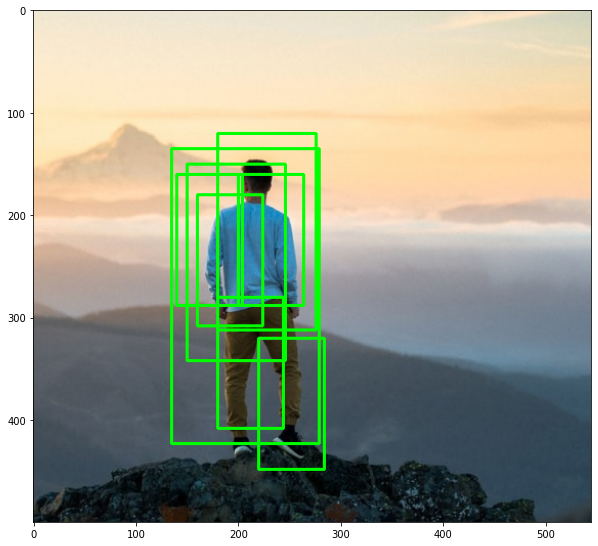

In [54]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,10))
resized = resized[:,:,::-1]
plt.imshow(resized)

- 上面结果可以看出我们已经用矩形框框出图片中的人了，但是我们也发现图中有太多的矩形框相互重叠、遮挡。
- 在下一节实验中我们将剔除冗余的矩形框，让每个目标值被一个矩形框标记。
- 通过观察图片我们还会发现有些没有人的地方也被矩形框标记了，其原因是这些地方可能和人比较相似或我们的模型不够鲁棒，我们可以通过**增加训练样本或把这些被误认为是人的区域放入训练样本中进行训练来解决这个问题。**